# Reprocessing of Copper in Germany

**IGA project / EEIOA 2024**

Collaborative projects (3 group members)

Working with Exiobase data from 2019 (IOT_2019_ixi.zip) https://zenodo.org/record/5589597dt

## 1) Load and calculate basic matrices 

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "C:/Users/paula/Documents/01_IE Master/00_Courses/S02Q03/EEIOA/IGA Assignment/Code/data/IOT_2019_ixi"

A = pd.read_csv(f'{path}/A.txt', sep='\t',
                index_col=[0, 1], header=[0, 1])  # A matrix
Y = pd.read_csv(f'{path}/Y.txt', sep='\t',
                index_col=[0, 1], header=[0, 1])  # Y matrix

F = pd.read_csv(f'{path}/satellite/F.txt', sep='\t',
                index_col=[0], header=[0, 1])  # satellites matrix
F_hh = pd.read_csv(f'{path}/satellite/F_Y.txt', sep='\t',
                index_col=[0], header=[0, 1])  # satellites for FD matrix

M = pd.read_csv(f'{path}/impacts/F.txt', sep='\t',
                index_col=[0], header=[0, 1])  # impacts matrix
M_hh = pd.read_csv(f'{path}/impacts/F_Y.txt', sep='\t',
                index_col=[0], header=[0, 1])  # impacts for FD matrix

I = np.identity(A.shape[0]) # A.shape[0] is the total number of columns in the A matrix
L = np.linalg.inv(I-A)

x = L@Y.sum(axis=1)

# we make a copy of our product output vector
x_ = x.copy() 

# we divide 1 by the values that are non-0
x_[x_!=0] = 1/x_[x_!=0]

# We diagolize the resulting vector: Also eine Matrix kreieren wo der Vektor auf der Diagonalen steht 
inv_diag_x = np.diag(x_)

f = F @ inv_diag_x # intensities of the environmental extensions
m = M @ inv_diag_x # intensities of the impacts (i.e., characterized extensions)

## 2) Insights into the Copper industry in Germany

Supply to the German Copper production

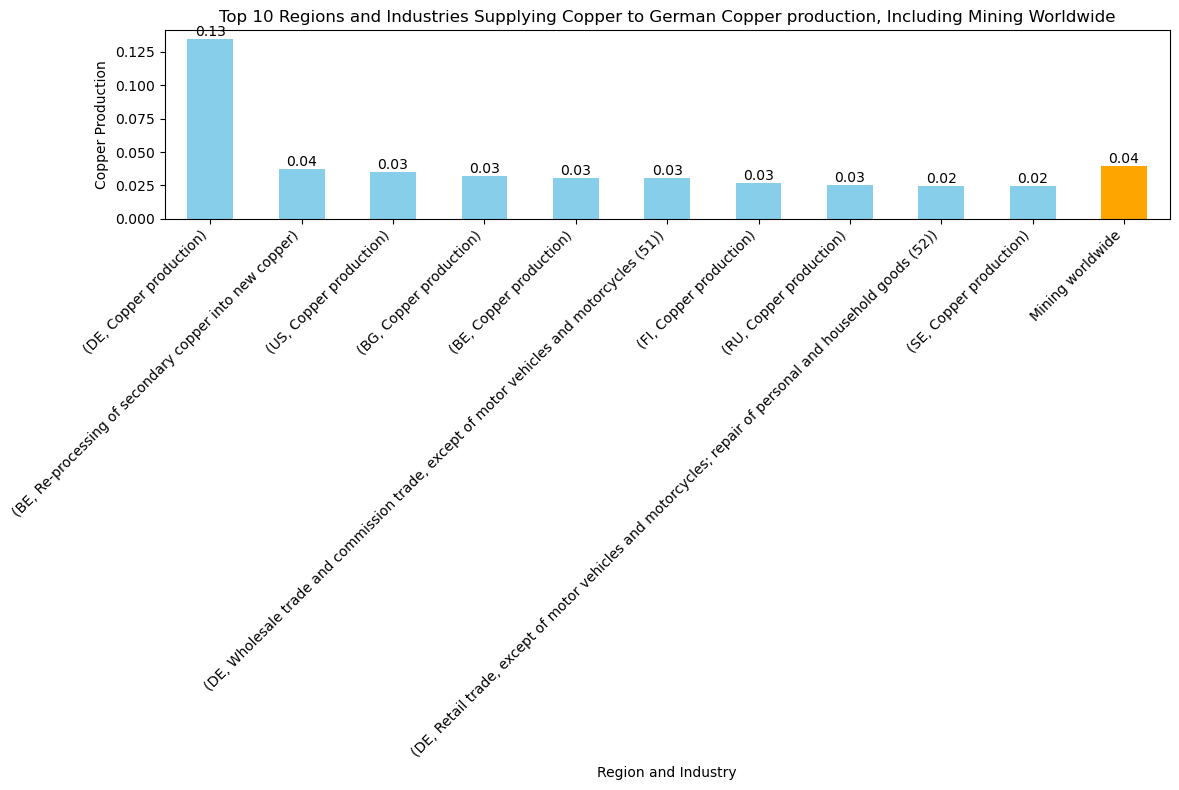

In [2]:
sorted_column2 = A.loc[pd.IndexSlice[:,:], pd.IndexSlice["DE", "Copper production"]].sort_values(ascending=False)

# Select the top 10 values
top_10 = sorted_column2.head(10)

# Plotting the top 10 values as a bar chart
plt.figure(figsize=(12, 8))
ax = top_10.plot(kind='bar', color='skyblue')

# Add the additional data point
additional_data = pd.Series([0.03957677727709755], index=["Mining worldwide"])
top_11 = pd.concat([top_10, additional_data])

# Define the colors for the bars
bar_colors = ['skyblue'] * 10 + ['orange']  # Last bar in a different color

# Plotting the top 11 values as a bar chart with the specified colors
top_11.plot(kind='bar', ax=ax, color=bar_colors)

# Adding title and labels
plt.title('Top 10 Regions and Industries Supplying Copper to German Copper production, Including Mining Worldwide')
plt.xlabel('Region and Industry')
plt.ylabel('Copper Production')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding numeric values above the bars
for i, value in enumerate(top_11):
    ax.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Adjust layout to ensure everything fits
plt.tight_layout()

# Save and display the plot
plt.savefig("Industries-supplying-to-copper-production.png", dpi=300, bbox_inches='tight')
plt.show()

Supply to the German Copper Reprocessing

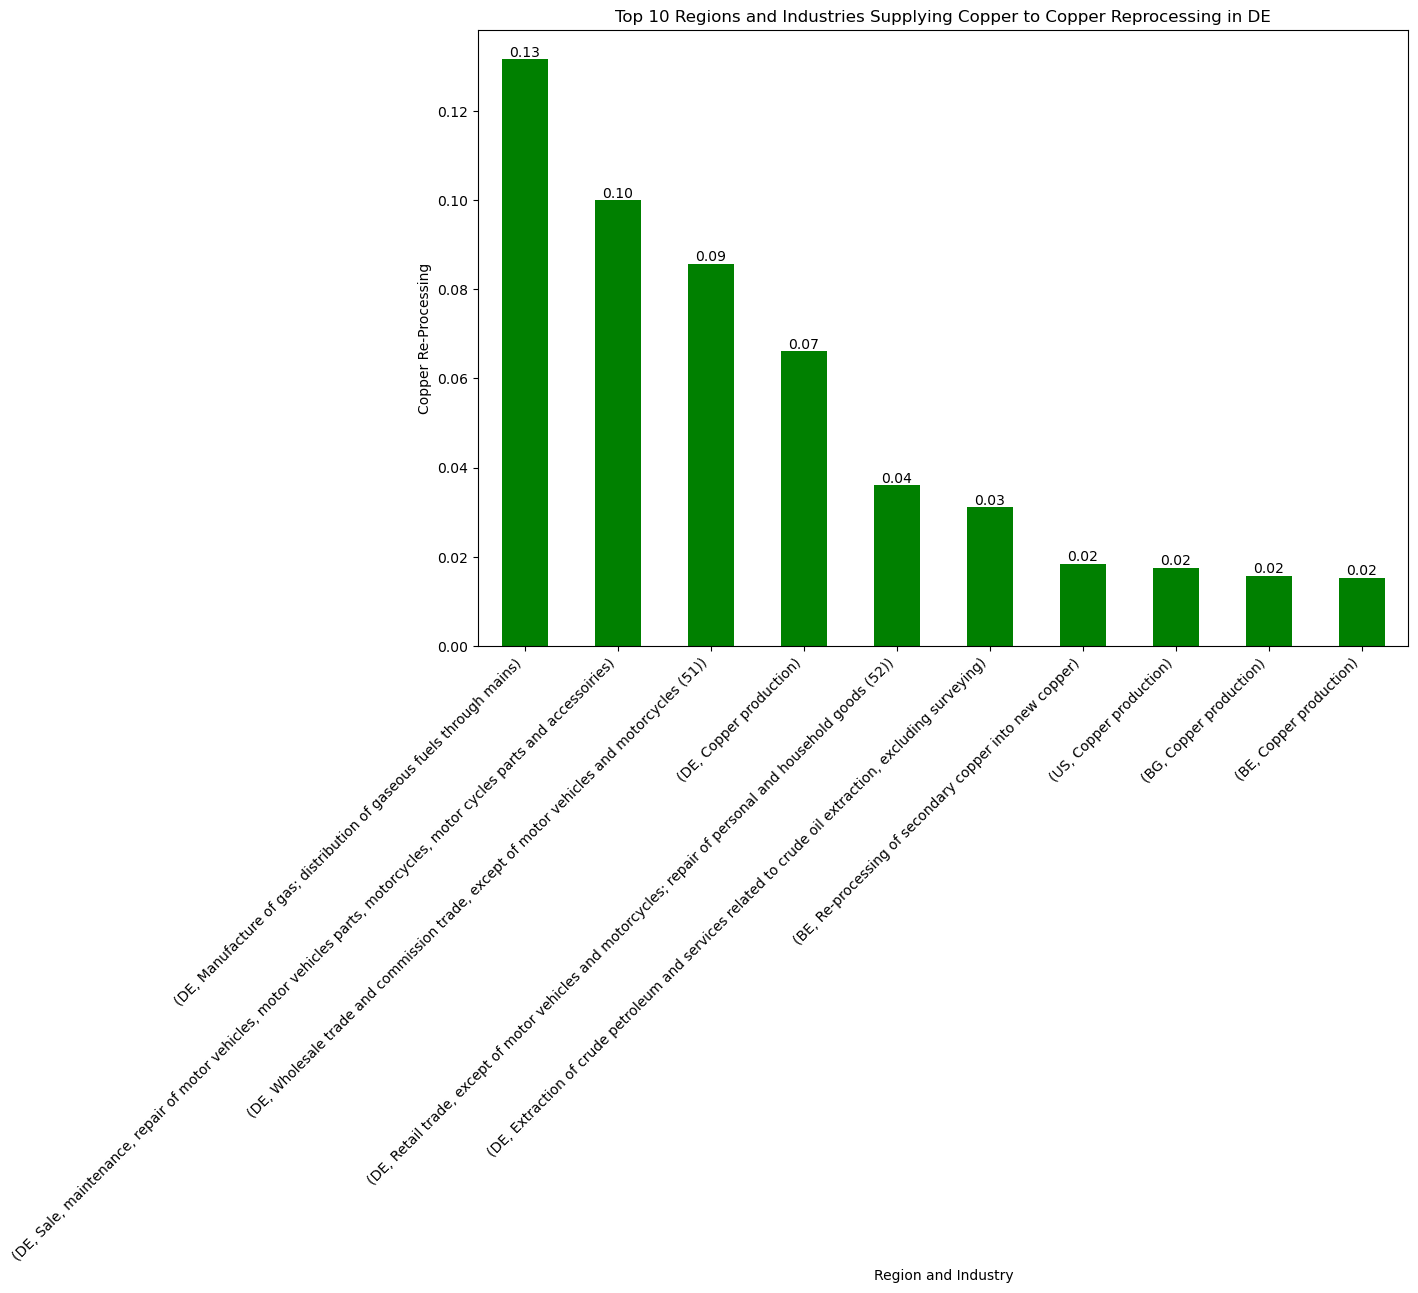

In [3]:

sorted_column = A.loc[pd.IndexSlice[:,:], pd.IndexSlice["DE", "Re-processing of secondary copper into new copper"]].sort_values(ascending=False)
sorted_column

# Select the top 10 values
top_10 = sorted_column.head(10)

# Plotting the top 10 values as a bar chart
plt.figure(figsize=(12, 8))
ax = top_10.plot(kind='bar', color= "green")

# Adding title and labels
plt.title('Top 10 Regions and Industries Supplying Copper to Copper Reprocessing in DE')
plt.xlabel('Region and Industry')
plt.ylabel('Copper Re-Processing')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding numeric values above the bars
for i, value in enumerate(top_10):
    ax.text(i, value, f'{value:.2f}', ha='center', va='bottom')
plt.savefig("Industries supplying to copper re-processing", dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

## 3) Circular intervention: Higher re-processing of Cu in Germany

Corresponding is:

A* = A(1+ka) with ka = kt*kp

kt = 22.49% higher reprocessing
kp = 100% as the whole market of reprocessing in Germany is affected

We apply the change to the row ("DE", "Re-processing of secondary copper into new copper") as the industry of copper re-processing is growing according to out policy change. 

In [4]:
A_ct = A.copy()

# Define region
region = "DE"

# Primary change
category_1 = "Re-processing of secondary copper into new copper"
change_1 = {"kt": 0.2249, "kp": 1} 

A_ct.loc[pd.IndexSlice[:,:], pd.IndexSlice[region, category_1]] *= 1 + change_1["kt"] * change_1["kp"] 

In [5]:
# Secondary change
change_2 = {"kt": 0.2249, "kp": 1}

# (1) The increased copper re-processing leads to an increased supply of secondary copper to the German copper production.
category_2_1 = "Re-processing of secondary copper into new copper"
category_2_2 = "Copper production"

A_ct.loc[pd.IndexSlice[region, category_2_1], pd.IndexSlice[region, category_2_2]] *= 1 + change_2["kt"] * change_2["kp"] 

# (2) Decrease what DE Copper production buys but not the industry of copper reprocessing
change_3 = {"kt": -0.2249, "kp": 1}
exclude_name = "Re-processing of secondary copper into new copper"
# Create a boolean mask for rows where the industry is not equal to re-processing
mask = A_ct.index.get_level_values(1) != exclude_name

# Apply the change only to the rows where mask is True
A_ct.loc[pd.IndexSlice[:, mask], pd.IndexSlice[region, category_2_2]] *= 1 + change_3["kt"] * change_3["kp"]


## 4) Calculate the new (counterfactual) gross output

In [6]:
L_ct = np.linalg.inv(I-A_ct)

x_ct = L_ct@Y.sum(axis=1)
F_ct = f * x_ct #Here we will multiply all matrix f by the x'. Makes easier selecting the indicators later
F_ct.columns = A.columns #After the multiplication the columns labels are lost, we add them again

M_ct = m*x_ct #Same for the impacts matrix
M_ct.columns = A.columns

## 5) Checking the balance

In [7]:
# Check the balancing of your system (A coefficients)

coef_balance = A_ct.sum(0) + f.iloc[:9].sum().values

#A_ct.sum(0) - total what the industries supply 
# f.iloc[:9] spalten sind alle industries und die impacts die man sich ansehen will, they sum by industries and put it in an array
# f.iloc[:9].sum()- all the impacts aggregrated to the industries

coef_balance[coef_balance!=0].sort_values(ascending=False)

# Check the balancing of your system after transformation to assess where your imbalances are

x_ct_out = L_ct@Y.sum(1)
x_ct_in = (A_ct@np.diag(x_ct_out)).sum(0) + m.loc["Value Added"].values *x_ct_out

balance_check = (x_ct_in - x_ct_out)/x_ct_out *100 # Expressed in percentages
balance_check = pd.Series(balance_check.values, index=Y.index).dropna().sort_values(ascending=False)
balance_check[balance_check!=0]

region  sector                                                                               
DE      Re-processing of secondary copper into new copper                                        20.157897
ZA      Re-processing of secondary plastic into new plastic                                       0.978419
CH      Re-processing of secondary paper into new pulp                                            0.747326
        Re-processing of secondary other non-ferrous metals into new other non-ferrous metals     0.747326
        Re-processing of secondary copper into new copper                                         0.747326
                                                                                                   ...    
SE      Production of electricity by solar photovoltaic                                          -0.000199
KR      Wool, silk-worm cocoons                                                                  -0.000761
GR      Mining of precious metal ores and concentr

## 6) Evaluating the impact of the intervention

#### 6.1) Definition of indicators
Define the indicators in a dictionary to access them seperately per region. Definition of a function to access these indicators. 

In [8]:
# Define indicators
indicators = {
    "CO2": "CO2 - combustion - air",
    "CH4": "CH4 - combustion - air",
    "N2O": "N2O - combustion - air",
    "EF": "Energy Carrier Use: Total",
    "WF_1": "Water Consumption Blue - Manufacturing - Copper products",
    "WF_2": "Water Consumption Blue - Manufacturing - Secondary copper for treatment, Re-processing of secondary copper into new copper"
}

# Employment indicator handled separately, because grouping needed
employment_indicator = "Employment hours"

def extract_indicators(grouped_df, indicators):
    # Function to extract specific indicators from a grouped DataFrame
    # Inputs:
        # - grouped_df (pandas.DataFrame): The DataFrame containing grouped data.
        # - indicators (dict): A dictionary with indicator names as keys and corresponding DataFrame indices as values.
    # Outputs:
        # - extracted (dict): A dictionary with indicator names as keys and extracted data as values.
    extracted = {}
    for key, value in indicators.items():
        try:
            extracted[key] = grouped_df.loc[value]
        except KeyError:
            print(f"Indicator '{value}' not found in the DataFrame.")
    return extracted

#### 6.2 Loading the satellites and the counter-scenario satellites

In [9]:
# Grouping the baseline F matrix
F_grouped = F.T.groupby(level=0).sum().T

# Extracting baseline indicators
F_reg = extract_indicators(F_grouped, indicators)

#Employment has to be handled differently: All indicators are added which have "employment" in their name 
F_reg["SE"] = F_grouped[F_grouped.index.str.contains(employment_indicator)].sum(axis=0)

# Grouping the new scenario F_ct matrix
F_ct_grouped = F_ct.T.groupby(level=0).sum().T

# Extracting new scenario indicators
F_ct_reg = extract_indicators(F_ct_grouped, indicators)
F_ct_reg["SE"] = F_ct_grouped[F_ct_grouped.index.str.contains(employment_indicator)].sum(axis=0)

In [10]:
# Now we have the indicators in dictionaries, which we can access as follows:
# Baseline scenario
F_reg_CO2 = F_reg["CO2"]
F_reg_CH4 = F_reg["CH4"]
F_reg_N2O = F_reg["N2O"]
F_reg_EF = F_reg["EF"]
F_reg_WF_1 = F_reg["WF_1"]
F_reg_WF_2 = F_reg["WF_2"]
F_reg_SE = F_reg["SE"]

# New scenario
F_ct_reg_CO2 = F_ct_reg["CO2"]
F_ct_reg_CH4 = F_ct_reg["CH4"]
F_ct_reg_N2O = F_ct_reg["N2O"]
F_ct_reg_EF = F_ct_reg["EF"]
F_ct_reg_WF_1 = F_ct_reg["WF_1"]
F_ct_reg_WF_2 = F_ct_reg["WF_2"]
F_ct_reg_SE = F_ct_reg["SE"]

#### 6.3 Division of analyzed regions

In [36]:
regions = {
    "Germany": [
        "DE",
    ],
    "EU27": [
        "AT","BE","BG","CY","CZ","DK","EE","ES","FI","FR","GR","HR","HU","IE","IT","LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK"
    ],
    "Rest of the World": [
        "GB","US","JP","CN","CA","KR","BR","IN","MX","RU","AU","CH","TR","TW","NO","ID","ZA","WA","WL","WE","WF","WM"
    ],
}

Definition of a function that aggregates over the F of the different regions and puts it in a dictionary. 

In [37]:
def aggregate_emissions(region_list, F_reg):
    # Function to aggregate emissions data for a specified region.
    # Inputs:
        # - region_list (list): A list of country codes representing the region whose emissions data are to be aggregated.
        # - F_reg (pandas.DataFrame): A DataFrame containing emission factors.
    # Output:
        # - emissions (dict): A dictionary where the keys are emission types and the values are numpy arrays
                #(arrays containing the aggregated emission data for each country in the specified region)
    # The function iterates over the list of countries and the emission types, appending the corresponding emission data from the DataFrame to the numpy arrays in the dictionary.
    emissions = {
        "CO2": np.array([]),
        "CH4": np.array([]),
        "N2O": np.array([]),
        "EF": np.array([]),
        "WF_1": np.array([]),
        "WF_2": np.array([]),
        "SE": np.array([])
    }
    
    for country in region_list:
        for key in emissions.keys():
            if key in F_reg and country in F_reg[key].index:
                emissions[key] = np.append(emissions[key], F_reg[key].loc[country])
    
    return emissions

Creating dictionaries for the EU-27 and the RoW-countries.

In [38]:
# We create a list for every indicator
EU27_emissions = aggregate_emissions(regions["EU27"], F_reg)
EU27_ct_emissions = aggregate_emissions(regions["EU27"], F_ct_reg)

# We create a list for every indicator
ROW_emissions = aggregate_emissions(regions["Rest of the World"], F_reg)
ROW_ct_emissions = aggregate_emissions(regions["Rest of the World"], F_ct_reg)

Definition of  function to calculate the relative changes.

In [39]:
def calculate_relative_values(list1, list2, delta_F_list, results_rel_F):
    # Function to calculate the absolute and relative differences between two lists of values.
    # Inputs:
        # - list1 (list): The first list of baseline values.
        # - list2 (list): The second list of intervention values.
        # - delta_F_list (list): An empty list to which the absolute differences between corresponding elements of list1 and list2 will be appended.
        # - results_rel_F (list): An empty list to which the relative differences (as percentages) between corresponding elements of list1 and list2 will be appended.
    # Output:
        # - delta_F_list (list): A list containing the absolute differences between corresponding elements of list1 and list2.
        # - results_rel_F (list): A list containing the relative differences (as percentages) between corresponding elements of list1 and list2.    
    delta_F_list.clear()
    results_rel_F.clear()
    for i in range(len(list1)):
        delta_F_value = list1[i] - list2[i]
        delta_F_list.append(delta_F_value)

        if list1[i] != 0:
            rel_F = (delta_F_value / list1[i]) * 100
            results_rel_F.append(rel_F)
        else:
            results_rel_F.append(np.nan)
            
    return delta_F_list, results_rel_F

#### 6.4 Calculation of Emissions

First we define lists to store the results.

In [40]:
ghg_emissions_baseline = [] #unit kg CO2e
ghg_emissions_intervention = [] #unit kg CO2e
ghg_emissions_delta = [] #unit kg CO2e
ghg_emissions_rel = [] #unit %

ghg_Copper_production = [] #unit kg CO2e
ghg_Copper_production_ct = [] #unit kg CO2e
ghg_Copper_production_delta = [] #unit kg CO2e
ghg_Copper_production_rel = [] #unit %

ghg_Copper_Reprocessing = [] #unit kg CO2e
ghg_Copper_Reprocessing_ct = [] #unit kg CO2e
ghg_Copper_Reprocessing_delta = [] #unit kg CO2e
ghg_Copper_Reprocessing_rel = [] #unit % 

energy_baseline = [] #unit TJ
energy_intervention = [] #unit TJ
energy_delta = [] #unit TJ
energy_rel = [] #unit %

WF1_baseline = [] #unit Mm3
WF1_intervention = [] #unit Mm3
WF1_delta = [] #unit Mm3
WF1_rel = [] #unit %

WF2_baseline = [] #unit Mm3
WF2_intervention = [] #unit Mm3
WF2_delta = [] #unit Mm3
WF2_rel = [] #unit %

employment_baseline = [] #unit M.hr
employment_intervention = [] #unit M.hr
employment_delta = [] #unit M.hr
employment_rel = [] #unit %

Then we define a function to calculate the relative change of indicator.

**Greenhouse gas emissions**

In [41]:
# Define a function to calculate emissions
def calculate_ghg(F_reg, country_code, mylist):
    # Function to calculate greenhouse gas (GHG) emissions for a specified country and append the result to a list.
    # Inputs:
        # - F_reg (pandas.DataFrame): A DataFrame containing emission data for different gases (CO2, CH4, N2O) across various countries.
        # - country_code (str): The country code used to locate the specific country's emission data in the DataFrame.
        # - mylist (list): A list to which the calculated GHG emission value will be appended.
    # Output:
        # - F_EM (float): The calculated GHG emissions for the specified country, using GWP (Global Warming Potential) values from AR5 (IPCC, 2013).
    # The GHG emissions are calculated as the sum of CO2 emissions plus 28 times the CH4 emissions plus 288 times the N2O emissions.
    # (IPCC, 2013: Climate Change 2013: The Physical Science Basis. Contribution of Working Group I to the Fifth Assessment Report 
    # of the Intergovernmental Panel on Climate Change [Stocker, T.F., D. Qin, G.-K. Plattner, M. Tignor, S.K. Allen, J. Boschung, A. Nauels, 
    # Y. Xia, V. Bex and P.M. Midgley (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA, 1535 pp, 
    # doi:10.1017/CBO9781107415324.)
    F_CO2 = F_reg["CO2"].loc[country_code]
    F_CH4 = F_reg["CH4"].loc[country_code]
    F_N2O = F_reg["N2O"].loc[country_code]
    F_EM = F_CO2 + F_CH4 * 28 + F_N2O * 288  # Multiplying by GWP values from AR5
    mylist.append(F_EM)
    return F_EM

def calculate_ghg_industries(F, country_code, industry, mylist):
    # Function to calculate greenhouse gas (GHG) emissions for a specified country and append the result to a list.
    # Inputs:
        # - F_reg (pandas.DataFrame): A DataFrame containing emission data for different gases (CO2, CH4, N2O) across various countries.
        # - country_code (str): The country code used to locate the specific country's emission data in the DataFrame.
        # - mylist (list): A list to which the calculated GHG emission value will be appended.
    # Output:
        # - F_EM (float): The calculated GHG emissions for the specified country, using GWP (Global Warming Potential) values from AR5 (IPCC, 2013).
    # The GHG emissions are calculated as the sum of CO2 emissions plus 28 times the CH4 emissions plus 288 times the N2O emissions.
    # (IPCC, 2013: Climate Change 2013: The Physical Science Basis. Contribution of Working Group I to the Fifth Assessment Report 
    # of the Intergovernmental Panel on Climate Change [Stocker, T.F., D. Qin, G.-K. Plattner, M. Tignor, S.K. Allen, J. Boschung, A. Nauels, 
    # Y. Xia, V. Bex and P.M. Midgley (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA, 1535 pp, 
    # doi:10.1017/CBO9781107415324.)
    F_CO2 = F.loc[pd.IndexSlice[indicators["CO2"]], pd.IndexSlice[country_code, industry]]
    F_CH4 = F.loc[pd.IndexSlice[indicators["CH4"]], pd.IndexSlice[country_code, industry]]
    F_N2O = F.loc[pd.IndexSlice[indicators["N2O"]], pd.IndexSlice[country_code, industry]]
    F_EM = F_CO2 + F_CH4 * 28 + F_N2O * 288  # Multiplying by GWP values from AR5
    mylist.append(F_EM)
    return F_EM

1. Germany

In [42]:
F_EM_germ = calculate_ghg(F_reg, "DE", ghg_emissions_baseline)
F_ct_EM_germ = calculate_ghg(F_ct_reg, "DE", ghg_emissions_intervention)

#Calculate the values not grouped by industry, but also specific to the copper industry
F_CO2_germ_reCu = calculate_ghg_industries(F, "DE", "Re-processing of secondary copper into new copper", ghg_Copper_Reprocessing)
F_CO2_germ_reCu_ct = calculate_ghg_industries(F_ct, "DE", "Re-processing of secondary copper into new copper", ghg_Copper_Reprocessing_ct)

F_CO2_germ_CuProd = calculate_ghg_industries(F, "DE", "Copper production", ghg_Copper_production)
F_CO2_germ_CuProd_ct = calculate_ghg_industries(F_ct, "DE", "Copper production", ghg_Copper_production_ct)

2. Europe

In [43]:
# Create a temporary DataFrame to represent the EU27 aggregated data
EU27_ghg_aggregated = pd.DataFrame({
    "CO2": [EU27_emissions["CO2"].sum()],
    "CH4": [EU27_emissions["CH4"].sum()],
    "N2O": [EU27_emissions["N2O"].sum()]
}, index=["EU27"])

# Calculate the baseline GHG emissions for the EU27 region
calculate_ghg(EU27_ghg_aggregated, "EU27", ghg_emissions_baseline)

EU27_ct_ghg_aggregated = pd.DataFrame({
    "CO2": [EU27_ct_emissions["CO2"].sum()],
    "CH4": [EU27_ct_emissions["CH4"].sum()],
    "N2O": [EU27_ct_emissions["N2O"].sum()]
}, index=["EU27"])

# Calculate the circular intervention GHG emissions for EU27
calculate_ghg(EU27_ct_ghg_aggregated, "EU27", ghg_emissions_intervention)


1849006818766.0295

In [44]:
# Calculate the emissions just for the copper and copper reprocessing industry
eu_countries = regions["EU27"]
EU_ghg_values_CuRepro = []
EU_ghg_values_CuPro = []
EU_ghg_values_CuRepro_ct = []
EU_ghg_values_CuPro_ct = []

# Iterating through each country in the EU27 list for "Re-processing of secondary copper into new copper"
for country in eu_countries:
    calculate_ghg_industries(F, country, "Re-processing of secondary copper into new copper", EU_ghg_values_CuRepro)
    calculate_ghg_industries(F_ct, country, "Re-processing of secondary copper into new copper", EU_ghg_values_CuRepro_ct)

ghg_Copper_Reprocessing.append(sum(EU_ghg_values_CuRepro))
ghg_Copper_Reprocessing_ct.append(sum(EU_ghg_values_CuRepro_ct))

# Iterating through each country in the EU27 list for "Copper production"
for country in eu_countries:
    calculate_ghg_industries(F, country, "Copper production", EU_ghg_values_CuPro)
    calculate_ghg_industries(F_ct, country, "Copper production", EU_ghg_values_CuPro_ct)

ghg_Copper_production.append(sum(EU_ghg_values_CuPro))
ghg_Copper_production_ct.append(sum(EU_ghg_values_CuPro_ct))

3. RoW countries

In [45]:
ROW_ghg_aggregated = pd.DataFrame({
    "CO2": [ROW_emissions["CO2"].sum()],
    "CH4": [ROW_emissions["CH4"].sum()],
    "N2O": [ROW_emissions["N2O"].sum()]
}, index=["EU27"])

ROW_ct_ghg_aggregated = pd.DataFrame({
    "CO2": [ROW_ct_emissions["CO2"].sum()],
    "CH4": [ROW_ct_emissions["CH4"].sum()],
    "N2O": [ROW_ct_emissions["N2O"].sum()]
}, index=["EU27"])

calculate_ghg(ROW_ghg_aggregated, "EU27", ghg_emissions_baseline)
calculate_ghg(ROW_ct_ghg_aggregated, "EU27", ghg_emissions_intervention)

26444630835652.49

In [46]:
# Calculate the emissions just for the copper and copper reprocessing industry
ROW_countries = regions["Rest of the World"]
ROW_ghg_values_CuRepro = []
ROW_ghg_values_CuPro = []
ROW_ghg_values_CuRepro_ct = []
ROW_ghg_values_CuPro_ct = []

# Iterating through each country in the EU27 list for "Re-processing of secondary copper into new copper"
for country in ROW_countries:
    calculate_ghg_industries(F, country, "Re-processing of secondary copper into new copper", ROW_ghg_values_CuRepro)
    calculate_ghg_industries(F_ct, country, "Re-processing of secondary copper into new copper", ROW_ghg_values_CuRepro_ct)

ghg_Copper_Reprocessing.append(sum(ROW_ghg_values_CuRepro))
ghg_Copper_Reprocessing_ct.append(sum(ROW_ghg_values_CuRepro_ct))

# Iterating through each country in the EU27 list for "Copper production"
for country in eu_countries:
    calculate_ghg_industries(F, country, "Copper production", ROW_ghg_values_CuPro)
    calculate_ghg_industries(F_ct, country, "Copper production", ROW_ghg_values_CuPro_ct)

ghg_Copper_production.append(sum(ROW_ghg_values_CuPro))
ghg_Copper_production_ct.append(sum(ROW_ghg_values_CuPro_ct))

Calculate the relative values

In [47]:
#using the predefined function
ghg_emissions_delta, ghg_emissions_rel = calculate_relative_values(ghg_emissions_baseline, ghg_emissions_intervention, ghg_emissions_delta, ghg_emissions_rel)

ghg_Copper_production_delta, ghg_Copper_production_rel = calculate_relative_values(ghg_Copper_production, ghg_Copper_production_ct, ghg_Copper_production_delta, ghg_Copper_production_rel)
ghg_Copper_Reprocessing_delta, ghg_Copper_Reprocessing_rel = calculate_relative_values(ghg_Copper_Reprocessing, ghg_Copper_Reprocessing_ct, ghg_Copper_Reprocessing_delta, ghg_Copper_Reprocessing_rel)

print(f"Relative change in GHG emissions are:\n{round(ghg_emissions_rel[0],2)}% in Germany \n{round(ghg_emissions_rel[1],2)}% in EU27 \n{round(ghg_emissions_rel[2],2)}% in RoW") 

Relative change in GHG emissions are:
0.06% in Germany 
0.02% in EU27 
0.0% in RoW


**Energy Carrier Use Total**

In [48]:
#Germany
F_germ_EF = F_reg_EF.loc["DE"]
F_ct_germ_EF = F_ct_reg_EF.loc["DE"]

#EU-27

EU27_EF_baseline = EU27_emissions["EF"].sum().item()
EU27_ct_EF = EU27_ct_emissions["EF"].sum().item()

#ROW
ROW_EF_baseline = ROW_emissions["EF"].sum().item()
ROW_ct_EF = ROW_ct_emissions["EF"].sum().item()

energy_baseline.extend([F_germ_EF, EU27_EF_baseline, ROW_EF_baseline])  # unit TJ
energy_intervention.extend([F_ct_germ_EF, EU27_ct_EF, ROW_ct_EF])       # unit TJ


energy_delta, energy_rel = calculate_relative_values(energy_baseline, energy_intervention, energy_delta, energy_rel)

print(f"Relative change in energy carries use are:\n{round(energy_rel[0],2)}% in Germany \n{round(energy_rel[1],2)}% in EU27 \n{round(energy_rel[2],2)}% in RoW") 

Relative change in energy carries use are:
0.05% in Germany 
0.02% in EU27 
0.0% in RoW


**Blue Water Consumption Copper Production**

In [49]:
#Germany
F_germ_WF1 = F_reg_WF_1.loc["DE"]
F_ct_germ_WF1 = F_ct_reg_WF_1.loc["DE"]

#EU-27

EU27_WF1_baseline = EU27_emissions["WF_1"].sum().item()
EU27_ct_WF1 = EU27_ct_emissions["WF_1"].sum().item()

#ROW
ROW_WF1_baseline = ROW_emissions["WF_1"].sum().item()
ROW_ct_WF1 = ROW_ct_emissions["WF_1"].sum().item()

WF1_baseline.extend([F_germ_WF1, EU27_WF1_baseline, ROW_WF1_baseline])  # unit Mm3
WF1_intervention.extend([F_ct_germ_WF1, EU27_ct_WF1, ROW_ct_WF1])       # unit Mm3

WF1_delta, WF1_rel = calculate_relative_values(WF1_baseline, WF1_intervention, WF1_delta, WF1_rel)

print(f"Relative change in blue water consumption are:\n{round(WF1_rel[0],2)}% in Germany \n{round(WF1_rel[1],2)}% in EU27 \n{round(WF1_rel[2],2)}% in RoW") 


Relative change in blue water consumption are:
3.69% in Germany 
2.33% in EU27 
0.16% in RoW


**Blue Water Consumption Secondary Copper Production**

Apparently the values for this indicator are zero. Nevertheless we wanted to show you, that we calculated the indicator. 

In [50]:
#Germany
F_germ_WF2 = F_reg_WF_2.loc["DE"]
F_ct_germ_WF2 = F_ct_reg_WF_2.loc["DE"]

#EU-27

EU27_WF2_baseline = EU27_emissions["WF_2"].sum().item()
EU27_ct_WF2 = EU27_ct_emissions["WF_2"].sum().item()

#ROW
ROW_WF2_baseline = ROW_emissions["WF_2"].sum().item()
ROW_ct_WF2 = ROW_ct_emissions["WF_2"].sum().item()

WF2_baseline.extend([F_germ_WF2, EU27_WF2_baseline, ROW_WF2_baseline])  # unit Mm3
WF2_intervention.extend([F_ct_germ_WF2, EU27_ct_WF2, ROW_ct_WF2])       # unit Mm3

WF2_delta, WF2_rel = calculate_relative_values(WF2_baseline, WF2_intervention, WF2_delta, WF2_rel)

print(f"Relative change in blue water consumption (secondary copper production) are:\n{round(WF2_rel[0],2)}% in Germany \n{round(WF2_rel[1],2)}% in EU27 \n{round(WF2_rel[2],2)}% in RoW") 


Relative change in blue water consumption (secondary copper production) are:
nan% in Germany 
nan% in EU27 
nan% in RoW


**Employment hours**

In [51]:
#Germany
F_germ_SE = F_reg_SE.loc["DE"]
F_ct_germ_SE = F_ct_reg_SE.loc["DE"]

#EU-27

EU27_SE_baseline = EU27_emissions["SE"].sum().item()
EU27_ct_SE = EU27_ct_emissions["SE"].sum().item()

#ROW
ROW_SE_baseline = ROW_emissions["SE"].sum().item()
ROW_ct_SE = ROW_ct_emissions["SE"].sum().item()

employment_baseline.extend([F_germ_SE, EU27_SE_baseline, ROW_SE_baseline])  # unit Mm3
employment_intervention.extend([F_ct_germ_SE, EU27_ct_SE, ROW_ct_SE])       # unit Mm3

employment_delta, employment_rel = calculate_relative_values(employment_baseline, employment_intervention, employment_delta, employment_rel)
print(f"Relative change in employment hours total are:\n{round(employment_rel[0],2)}% in Germany \n{round(employment_rel[1],2)}% in EU27 \n{round(employment_rel[2],2)}% in RoW") 


Relative change in employment hours total are:
0.03% in Germany 
0.01% in EU27 
0.0% in RoW


## 7) Visualisation and Results

**Dataframes of the results**

In [52]:
data = {
    "GHG emissions [kg Co2eq]": ghg_emissions_baseline,
    "Energy Carrier Use [TJ]": energy_baseline,
    "Blue Water Consumption Cu Production [Mm3]": WF1_baseline,
    "Blue Water Consumption Cu Re-Processing [Mm3]": WF2_baseline,
    "Employment hours [M.hr]": employment_baseline
}

df_base = pd.DataFrame(data, index=["Germany", "EU27", "RoW"])
df_base_formatted = df_base.round(4)

print("Baseline Indicators by region:")
df_base_formatted.T

Baseline Indicators by region:


,Germany,EU27,RoW
GHG emissions [kg Co2eq],6.327330e+11,1.849413e+12,2.644536e+13
Energy Carrier Use [TJ],1.988531e+07,8.047081e+07,7.190768e+08
Blue Water Consumption Cu Production [Mm3],8.203000e-01,1.334350e+01,3.767163e+02
Blue Water Consumption Cu Re-Processing [Mm3],0.000000e+00,0.000000e+00,0.000000e+00
Employment hours [M.hr],7.404660e+04,3.596972e+05,1.299490e+07


In [53]:
data = {
    "GHG emissions [kg Co2eq]": ghg_emissions_baseline,
    "Energy Carrier Use [TJ]": energy_baseline,
    "Blue Water Consumption Cu Production [Mm3]": WF1_baseline,
    "Blue Water Consumption Cu Re-Processing [Mm3]": WF2_baseline,
    "Employment hours [M.hr]": employment_baseline
}

df_intervention = pd.DataFrame(data, index=["Germany", "EU27", "RoW"])
df_interv_formatted = df_intervention.round(4)

print("Indicators after intervention by region:")
df_interv_formatted.T

Indicators after intervention by region:


,Germany,EU27,RoW
GHG emissions [kg Co2eq],6.327330e+11,1.849413e+12,2.644536e+13
Energy Carrier Use [TJ],1.988531e+07,8.047081e+07,7.190768e+08
Blue Water Consumption Cu Production [Mm3],8.203000e-01,1.334350e+01,3.767163e+02
Blue Water Consumption Cu Re-Processing [Mm3],0.000000e+00,0.000000e+00,0.000000e+00
Employment hours [M.hr],7.404660e+04,3.596972e+05,1.299490e+07


In [54]:
data = {
    "GHG emissions [kg Co2eq]": ghg_emissions_delta,
    "Energy Carrier Use [TJ]": energy_delta,
    "Blue Water Consumption Cu Production [Mm3]": WF1_delta,
    "Blue Water Consumption Cu Re-Processing [Mm3]": WF2_delta,
    "Employment hours [M.hr]": employment_delta
}

df_delta = pd.DataFrame(data, index=["Germany", "EU27", "RoW"])
df_delta_formatted = df_delta.round(4)

print("Difference in emissions after intervention by region:")
df_delta_formatted.T

Difference in emissions after intervention by region:


,Germany,EU27,RoW
GHG emissions [kg Co2eq],3.967811e+08,4.065740e+08,7.282274e+08
Energy Carrier Use [TJ],9.163826e+03,1.679739e+04,2.026880e+04
Blue Water Consumption Cu Production [Mm3],3.030000e-02,3.116000e-01,5.893000e-01
Blue Water Consumption Cu Re-Processing [Mm3],0.000000e+00,0.000000e+00,0.000000e+00
Employment hours [M.hr],2.332330e+01,2.342740e+01,4.211455e+02


In [55]:
data = {
    "GHG emissions": ghg_emissions_rel,
    "Energy Carrier Use": energy_rel,
    "Blue Water Consumption Cu Production": WF1_rel,
    "Blue Water Consumption Cu Re-Processing": WF2_rel,
    "Employment hours": employment_rel
}

df = pd.DataFrame(data, index=["Germany", "EU27", "RoW"])
df_formatted = df.round(4)

print("Relative Change Indicators by region [%]:")
df_formatted.T

Relative Change Indicators by region [%]:


,Germany,EU27,RoW
GHG emissions,0.0627,0.0220,0.0028
Energy Carrier Use,0.0461,0.0209,0.0028
Blue Water Consumption Cu Production,3.6937,2.3350,0.1564
Blue Water Consumption Cu Re-Processing,NaN,NaN,NaN
Employment hours,0.0315,0.0065,0.0032


In [56]:
data = {
    "GHG emissions baseline [kg Co2eq]": ghg_Copper_production,
    "GHG emissions intervention [kg CO2eq]": ghg_Copper_production_ct,
    "GHG relative change [%]": ghg_Copper_production_rel
}

df_CuProd = pd.DataFrame(data, index=["Germany", "EU27", "RoW"])
df_CuProd_formatted = df_CuProd.round(2)

print("Environmental impact from the copper production:")
df_CuProd_formatted.T

Environmental impact from the copper production:


,Germany,EU27,RoW
GHG emissions baseline [kg Co2eq],6.697411e+08,2.167691e+09,2.167691e+09
GHG emissions intervention [kg CO2eq],6.439130e+08,2.124685e+09,2.124685e+09
GHG relative change [%],3.860000e+00,1.980000e+00,1.980000e+00


In [57]:
data = {
    "GHG emissions baseline [kg Co2eq]": ghg_Copper_Reprocessing,
    "GHG emissions intervention [kg CO2eq]": ghg_Copper_Reprocessing_ct,
    "GHG emissions relative change [%]": ghg_Copper_Reprocessing_rel,
}

df_CuRep = pd.DataFrame(data, index=["Germany", "EU27", "RoW"])
df_CuRep_formatted = df_CuRep.round(2)

print("Environmental impact from the copper reprocessing:")
df_CuRep_formatted.T

Environmental impact from the copper reprocessing:


,Germany,EU27,RoW
GHG emissions baseline [kg Co2eq],7.674503e+08,1.326651e+09,1.187808e+09
GHG emissions intervention [kg CO2eq],7.823998e+08,1.319212e+09,1.186952e+09
GHG emissions relative change [%],-1.950000e+00,5.600000e-01,7.000000e-02


**Visualisation of the results**

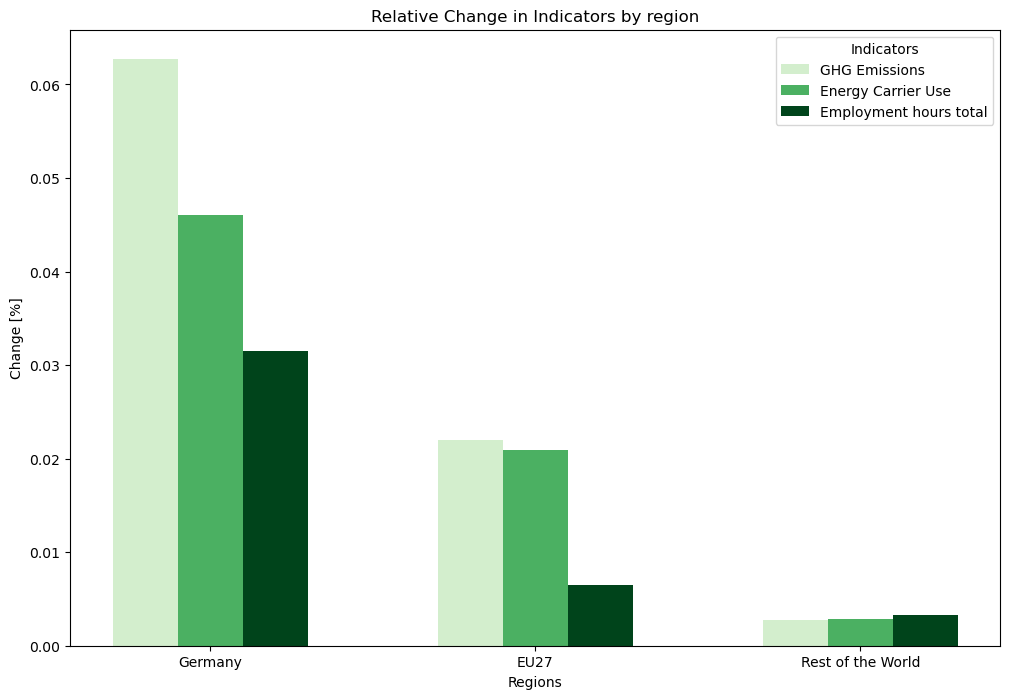

In [58]:
# Data
regions = ["Germany", "EU27", "Rest of the World"]

# Combine indicators for the first graph
rel_results1 = [ghg_emissions_rel, energy_rel, employment_rel]
indicator_names1 = ["GHG Emissions", "Energy Carrier Use", "Employment hours total"]

# Use the recommended way to get the colormap
cmap = plt.get_cmap('Greens')
# Adjust the colormap so it does not start with white
colors1 = [cmap(i / (len(rel_results1) - 1) * 0.8 + 0.2) for i in range(len(rel_results1))]

# Create a figure for the first graph
plt.figure(figsize=(12, 8))

# Define the width of each bar and the positions of the groups of bars
bar_width = 0.2
indices = np.arange(len(regions))

# Plot bars for each indicator
for i, indicator in enumerate(rel_results1):
    plt.bar(indices + i * bar_width, indicator, bar_width, label=indicator_names1[i], color=colors1[i])

# Adding titles and labels
plt.ylabel("Change [%]")
plt.xlabel("Regions")
plt.xticks(indices + bar_width * (len(rel_results1) - 1) / 2, regions)
plt.legend(title="Indicators", loc='upper right')

# Adding a legend with primary and secondary changes
primary_change_label = f"Primary change ({category_1}): kt = {change_1['kt']}, kp = {change_1['kp']}"
secondary_change_label = f"Secondary change: kt = {change_2['kt']}, kp = {change_2['kp']}"
plot_title = f"Relative Change in Indicators by region"
plt.title(plot_title)

# Saving the plot
filename1 = "relative_change_indicators_by_region_without_water.png"
plt.savefig(filename1, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

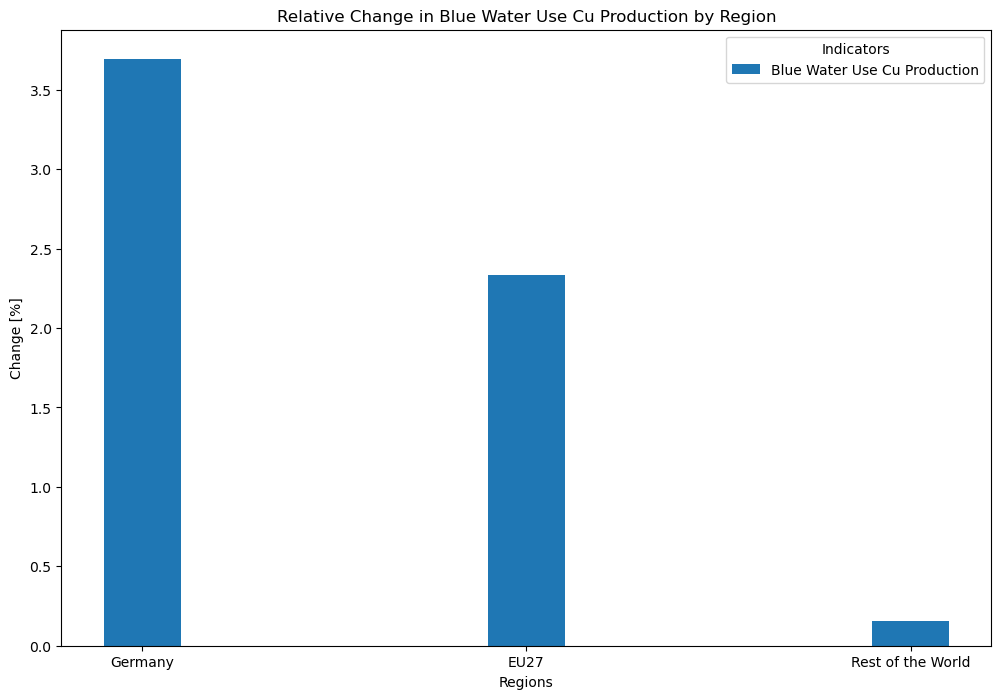

In [59]:
# Data
regions = ["Germany", "EU27", "Rest of the World"]

# Create a figure for the graph
plt.figure(figsize=(12, 8))

# Define the width of each bar and the positions of the bars
bar_width = 0.2
indices = np.arange(len(regions))

# Plot bars for WF1_rel
plt.bar(indices, WF1_rel, bar_width, label="Blue Water Use Cu Production")

# Adding titles and labels
plt.ylabel("Change [%]")
plt.xlabel("Regions")
plt.xticks(indices, regions)
plt.legend(title="Indicators", loc='upper right')

# Adding a title
plot_title = "Relative Change in Blue Water Use Cu Production by Region"
plt.title(plot_title)

# Saving the plot
filename = "relative_change_blue_water_use_cu_production_by_region.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

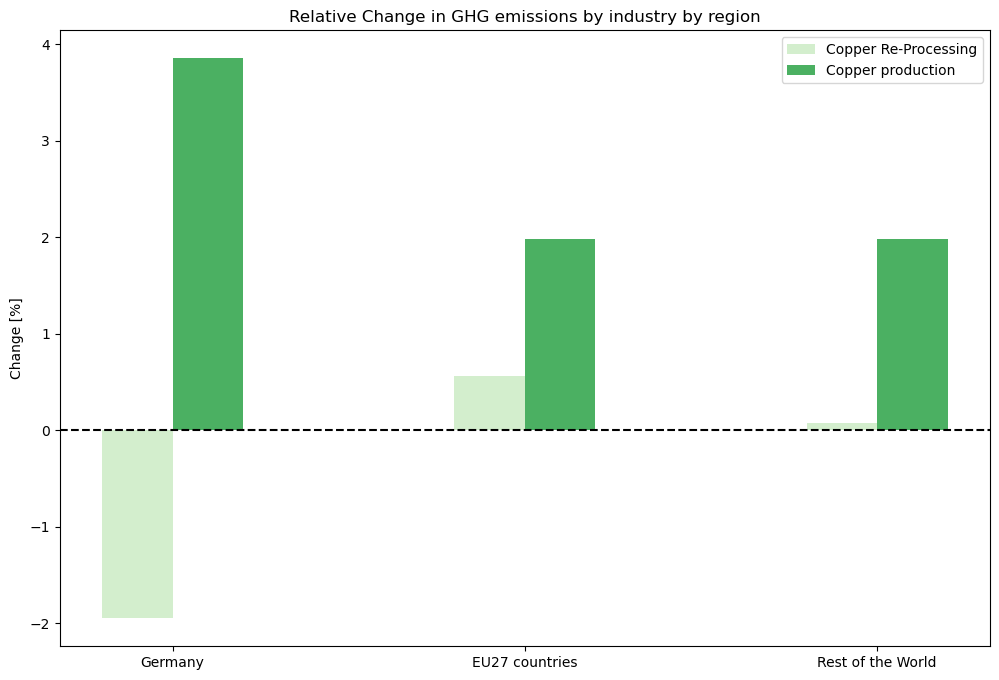

In [60]:
# Data
regions = ["Germany", "EU27 countries", "Rest of the World"]

# Combine indicators for the first graph
rel_results3 = [ghg_Copper_Reprocessing_rel, ghg_Copper_production_rel]
indicator_names3 = ["Copper Re-Processing", "Copper production"]

# Use the recommended way to get the colormap
cmap = plt.get_cmap('Greens')
# Adjust the colormap so it does not start with white
colors1 = [cmap(i / (len(rel_results1) - 1) * 0.8 + 0.2) for i in range(len(rel_results1))]

# Create a figure for the first graph
plt.figure(figsize=(12, 8))

# Define the width of each bar and the positions of the groups of bars
bar_width = 0.2
indices = np.arange(len(regions))

# Plot bars for each indicator
for i, indicator in enumerate(rel_results3):
    plt.bar(indices + i * bar_width, indicator, bar_width, label=indicator_names3[i], color=colors1[i])

# Add horizontal line at y = 0
plt.axhline(y=0, color='k', linestyle='--')

# Adding titles and labels
plt.ylabel("Change [%]")
plt.xticks(indices + bar_width * (len(rel_results3) - 1) / 2, regions)
plt.legend(loc='upper right')

# Adding a legend with primary and secondary changes
plot_title = f"Relative Change in GHG emissions by industry by region"
plt.title(plot_title)

# Saving the plot
filename1 = "relative_change_indicators_by_industry_by_region.png"
plt.savefig(filename1, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()